Original Initial State: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Reconstructed Initial State: [-0.3782+0.1877j -0.0859-0.2676j -0.0859-0.2676j -0.084 +0.1877j
 -0.4987+0.3754j -0.3782-0.4553j -0.3782-0.4553j  0.2084-0.2676j
 -0.0859-0.2676j -0.084 +0.1877j -0.084 +0.1877j -0.793 -0.9105j
 -0.3782-0.4553j  0.2084-0.2676j  0.2084-0.2676j -0.084 -0.4553j]


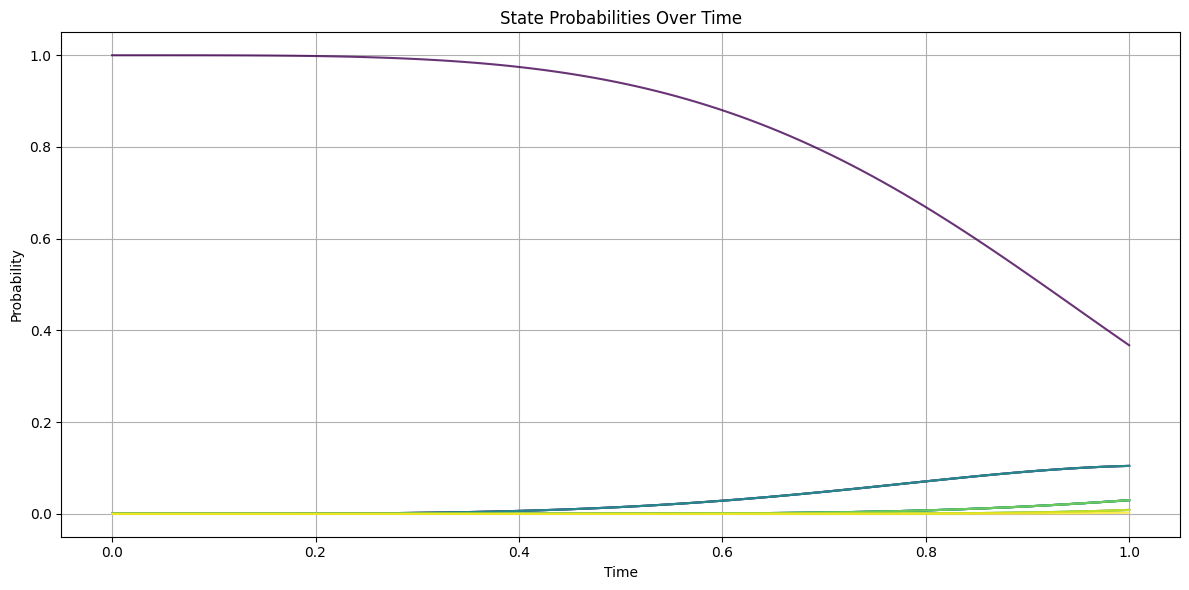

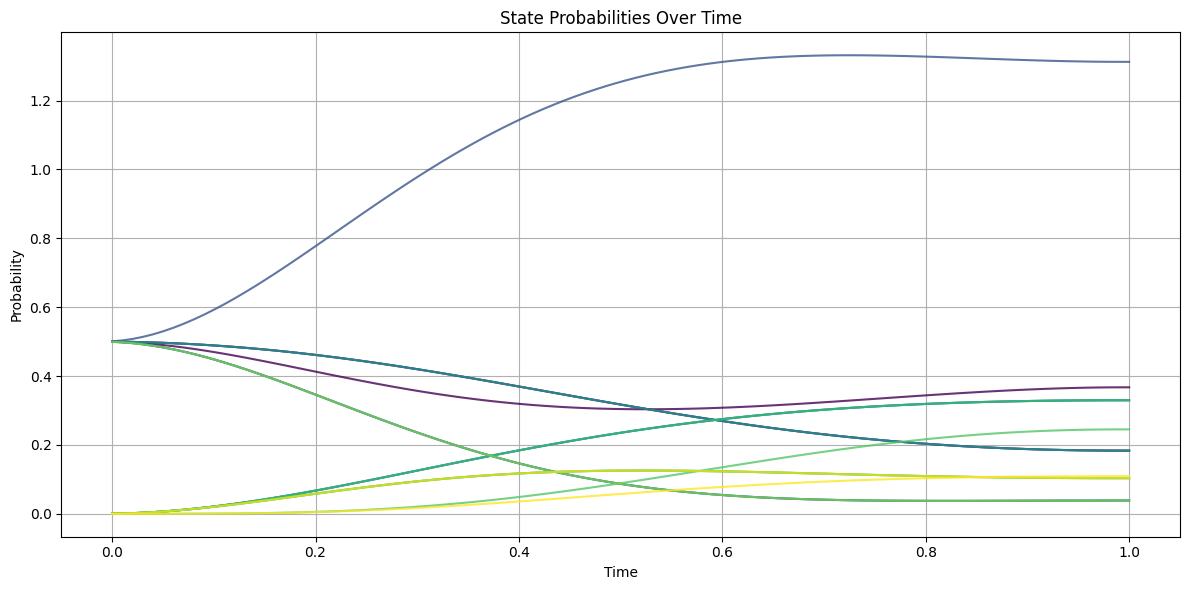

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

# Define Pauli matrices and Identity
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
H = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=complex)

def tensor_product(*matrices):
    """Compute the tensor product of multiple matrices."""
    result = matrices[0]
    for m in matrices[1:]:
        result = np.kron(result, m)
    return result

# Define initial state (|0000⟩)
def initial_state(N):
    psi_0 = np.zeros(2**N, dtype=complex)
    psi_0[0] = 1  # |0000⟩
    return psi_0

# Define initial Hamiltonian (e.g., simple Z interactions)
def initial_hamiltonian(N):
    H_init = sum(tensor_product(*(Z if i == j else I for i in range(N))) for j in range(N))
    return H_init

# Define oracle (random single-qubit X gates for now)
def apply_oracle(psi, N):
    oracle = sum(tensor_product(*(X if i == j else I for i in range(N))) for j in range(N))
    return oracle @ psi

# Define final Hamiltonian (can be based on the evolved state)
def final_hamiltonian(N):
    H_final = sum(tensor_product(*(X if i == j else I for i in range(N))) for j in range(N))
    return H_final

# Evolve system under Hamiltonian H for time t
def evolve(psi, H, t, steps=100):
    dt = t / steps
    U = expm(-1j * H * dt)
    for _ in range(steps):
        psi = U @ psi
    return psi

# Introduce Hadamard superposition at qubit q
def apply_hadamard(psi, q, N):
    H_q = tensor_product(*(H if i == q else I for i in range(N)))
    return H_q @ psi

# Quantum retrodiction (reverse evolution)
def retrodict(psi, H, t, steps=100):
    dt = t / steps
    U_dagger = expm(1j * H * dt)
    for _ in range(steps):
        psi = U_dagger @ psi
    return psi

timesteps = 100
T = 1.0

# Store evolution states
psi_evolution = []
states_over_time = []
H_ts_over_time = []
psi_retro_evolution = []
states_retro_over_time = []
psi_retro_evolution = []


N = 4  # Number of qubits
t = 1.0  # Evolution time

# Step 1: Initialize system
psi_init = initial_state(N)
H_init = initial_hamiltonian(N)

# Step 2: Apply oracle
psi_final = apply_oracle(psi_init, N)
H_final = final_hamiltonian(N)

# Step 3: Evolve from H_init to H_final
psi_evolved = evolve(psi_init, H_final, T, timesteps)
current_state = psi_init.copy()
for t in np.linspace(0, T, timesteps):
    s = t / T
    H_t = (1 - s) * H_init + s * H_final  # Interpolated Hamiltonian
    U = expm(-1j * H_t * (T / timesteps))
    current_state = U @ current_state
    states_over_time.append((t, current_state))
    H_ts_over_time.append((t, H_t))

# Step 4: Apply Hadamard superposition to one qubit in both states
psi_init_h = apply_hadamard(psi_init, 0, N)
psi_final_h = apply_hadamard(psi_final, 1, N)

# Step 5: Retrodict initial state
psi_reconstructed = retrodict(psi_final_h, H_final, T, timesteps)
current_state = psi_final_h.copy()
for t in np.linspace(0, T, timesteps):
    s = (T - t) / T
    H_t = (1 - s) * H_init + s * H_final  # Interpolated Hamiltonian
    U = expm(1j * H_t * (T / timesteps))
    current_state = U @ current_state
    states_retro_over_time.append((t, current_state))

# Compare results
print("Original Initial State:", np.round(psi_init, 4))
print("Reconstructed Initial State:", np.round(psi_reconstructed, 4))

def plot_state_probabilities(states_over_time):
    num_states = len(states_over_time[0][1])
    probabilities_over_time = []
    time_points = []
    
    for t, state in states_over_time:
        probabilities = np.abs(state)**2
        probabilities_over_time.append(probabilities)
        time_points.append(t)
    
    probabilities_over_time = np.array(probabilities_over_time)
    time_points = np.array(time_points)
    
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, num_states))
    for state_idx in range(num_states):
        plt.plot(time_points, probabilities_over_time[:, state_idx], color=colors[state_idx], alpha=0.8)
    plt.title("State Probabilities Over Time")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.tight_layout()
    

# Plot Evolution

plot_state_probabilities(states_over_time)
plot_state_probabilities(states_retro_over_time)

plt.show()
